In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import beir 
from beir import util, LoggingHandler
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval

from utils_func import corpus_processing, matrix_creation, clustering, retriever_model

import optuna

import os

c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\beir\util.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Example corpus and queries (replace with your actual data)

dataset = "nfcorpus"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
data_path = util.download_and_unzip(url, "datasets")
data_path = f"datasets/{dataset}"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

100%|██████████| 3633/3633 [00:00<00:00, 112015.43it/s]


In [3]:
embeddings = pd.read_csv(f'word_vectors_{dataset}.txt', sep=' ',na_values=[''], keep_default_na=False, index_col=0).dropna()
#embeddings.columns = ['word'] + [str(i) for i in range(100)]
for i in list(embeddings.columns)[1:]:
    embeddings[i] = embeddings[i].astype(float)

#embeddings = embeddings.set_index('word')

In [4]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126,-0.011044,0.058217,0.141033,-0.341268,-0.015768,0.003940,-0.175467,-0.144078,0.264548,-0.051928,...,-0.080752,0.664248,-0.297029,-0.210660,-0.193502,0.036609,-0.091867,0.359317,-0.082473,-0.490378
34.24,0.030947,-0.121440,0.054609,-0.084498,-0.053312,0.044570,-0.103145,-0.091805,0.036537,-0.045122,...,0.019651,0.182591,-0.135279,-0.033207,-0.109306,-0.005387,-0.088273,0.167130,-0.070896,-0.219247
35–52,0.014609,-0.021557,0.040719,-0.071937,-0.026585,0.028045,-0.034280,0.005987,0.067288,-0.032847,...,-0.012204,0.146577,-0.069230,-0.030009,-0.027265,0.013763,-0.022396,0.073876,-0.038226,-0.075663
nonenzymatic,0.027821,-0.350762,0.060792,-0.032954,-0.242349,0.270953,-0.284467,-0.016168,-0.130657,-0.119629,...,0.207984,0.083003,-0.060294,0.235988,0.176164,0.012528,-0.402212,0.179356,-0.328949,-0.324046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nontyphoidal,0.056928,-0.387332,0.050045,0.097522,-0.089411,0.362372,-0.045939,-0.057368,-0.016160,-0.158027,...,0.195139,0.096966,-0.099858,0.119698,0.080288,0.038749,-0.155328,0.293395,-0.120318,-0.087386
insecticides,0.013313,-0.143795,0.092688,-0.050681,-0.050107,0.150434,0.139261,0.278535,-0.072205,-0.072606,...,0.075099,0.288328,-0.081073,-0.100547,0.132318,0.323047,0.244968,0.204230,0.050586,-0.325774
1735,0.029992,-0.085453,0.078009,-0.096499,-0.009471,0.093347,-0.063001,-0.031006,0.117415,-0.041062,...,-0.006004,0.271258,-0.207815,-0.066118,-0.093946,-0.022465,-0.043940,0.201661,-0.089507,-0.263998
-5.74,0.019313,-0.046945,0.045838,-0.091351,-0.050979,0.040370,-0.021837,-0.009942,0.060822,-0.028762,...,0.005205,0.176974,-0.072228,-0.016170,-0.054377,0.024676,-0.039392,0.077269,-0.006222,-0.110795


# Corpus cleaning

In [4]:
cleaned_corpus = corpus_processing.preprocess_corpus_dict(corpus)

100%|██████████| 3633/3633 [00:27<00:00, 132.63it/s]


In [4]:
cleaned_corpus

{'c67482ba-2019-04-18T13:32:05Z-00000-000': 'contraceptive form high school student opponent forfeit round argument answer like idea win default are.tule ’ good student involved address big issue like teen pregnancy need able answer argument like simply prepare abstinence type response aware u.s condom sell minor state retailer illegal sell frankly wrong',
 'c67482ba-2019-04-18T13:32:05Z-00001-000': 'contraceptive form high school student propose school fund program condom cost money check opt list hand time away staff member actual job opt option token parental authority easily subvert school handful student access free condom think student simply ask friend provide condom',
 'c67482ba-2019-04-18T13:32:05Z-00002-000': 'contraceptive form high school student school compelling interest provide contraceptive student purpose school provide healthcare provide service insofar relate furtherance education 1,2,3 contest individual district ought option choose educator feel adequate sexual edu

In [6]:
def save_cleaned_corpus(cleaned_corpus, dataset):
    with open(f'cleaned_corpus_{dataset}.txt', 'w') as f:
        for key in tqdm(cleaned_corpus.keys()):
            f.write(f'{key}\t{cleaned_corpus[key]}\n')

def load_cleaned_corpus(path):
    cleaned_corpus = {}
    with open(path, 'r') as f:
        for line in tqdm(f):
            key, value = line.split('\t')
            cleaned_corpus[key] = value
    return cleaned_corpus

def save_text(text, path):
    with open(path, 'w') as f:
        f.write(text)

        
#save_cleaned_corpus(cleaned_corpus, dataset)

In [7]:
cleaned_corpus = load_cleaned_corpus(f'cleaned_corpus_{dataset}.txt')

0it [00:00, ?it/s]

382545it [00:01, 265862.60it/s]


In [ ]:
with open(f'text_{dataset}.txt', 'w') as f:
    for key in tqdm(cleaned_corpus.keys()):
        f.write(f'{cleaned_corpus[key]}')

## Test

In [6]:
def words_coexistence_probability(corpus:dict[int, str]) -> pd.DataFrame:
    """
    Function to calculate the probability of coexistence of each pair of words in the corpus
    :param corpus: dict[int, str] - a dictionary with the key being the document id and the value being the document text
    :return: pd.DataFrame - a dataframe with the probability of coexistence of each pair of words in the corpus
    """
    word_presence = matrix_creation.get_word_presence(corpus)
    unique_words = list(matrix_creation.get_unique_words(corpus))
    #word_coexistence = pd.DataFrame(0.0,index=unique_words, columns=unique_words)
    print("Calculating coexistence probability")
    word_coexistence = np.array([[len(word_presence[unique_words[word1]].intersection(word_presence[unique_words[word2]]))/max(len(word_presence[unique_words[word1]] | word_presence[unique_words[word2]]), 1) for word1 in range(len(unique_words))] for word2 in tqdm(range(len(unique_words)))])
    print("Creating dataframe")
    word_coexistence = pd.DataFrame(word_coexistence, index=unique_words, columns=unique_words)
    return word_coexistence

In [7]:
dico = dict()
word_presence = matrix_creation.get_word_presence(cleaned_corpus)
unique_words = list(matrix_creation.get_unique_words(cleaned_corpus))

for word2 in tqdm(range(len(unique_words))):
    dico[unique_words[word2]] = dict()
    for word1 in range(len(unique_words)):
        inter = len(word_presence[unique_words[word1]].intersection(word_presence[unique_words[word2]]))
        if inter > 0:
            dico[unique_words[word2]][unique_words[word1]] = inter/max(len(word_presence[unique_words[word1]] | word_presence[unique_words[word2]]), 1)

100%|██████████| 671/671 [00:00<00:00, 3162.12it/s]


In [8]:
class coex_matrix:
    def __init__(self, dico:dict[str, dict[str, float]], unique_words:list[str]):
        self.dico = dico
        self.index = unique_words
    def __getitem__(self, key:str):
        return self.dico[key]
    
    def loc(self, word):
        temp = np.zeros(len(self.index))
        for i in list(self.dico[word].keys()):
            temp[self.index.index(i)] = self.dico[word][i]
        return pd.Series(temp)

In [9]:
test = coex_matrix(dico, unique_words)

In [55]:
def get_replaceable_words(similarity_matrix:pd.DataFrame, coexistence_matrix:pd.DataFrame, alpha = 0.5, thresh = 0.8) -> dict[str, set[str]]:
    """
    Get for each word, the set of words that can replace it in a sentence according to the constraints on similarity and coexistence matrix.\n
    :param similarity_matrix: A pandas DataFrame containing the similarity matrix between words.\n
    :param coexistence_matrix: A pandas DataFrame containing the coexistence matrix between words.\n
    :param alpha: A float between 0 and 1, the weight of the similarity matrix in the final decision.\n
    :param thresh: A float between 0 and 1, the threshold to consider a word as a possible replacement.\n
    :return: A dictionary containing for each word, the set of words that can replace it in a sentence.
    """
    all_words = list(set(similarity_matrix.index).intersection(set(coexistence_matrix.index)))
    all_words.sort()
    to_ret = {}
    similarity_matrix.sort_index(inplace=True)
    if type(coexistence_matrix) == coex_matrix:
        coexistence_matrix.index = all_words
        for word in tqdm(all_words):
            temp = alpha * similarity_matrix.loc[word] + (1-alpha) * coexistence_matrix.loc(word)
            to_ret[word] = set(temp[temp > thresh].index)
    else:
        coexistence_matrix.sort_index(inplace=True)
        for word in tqdm(all_words):
            temp = alpha * similarity_matrix.loc[word] + (1-alpha) * coexistence_matrix.loc[word]
            to_ret[word] = set(temp[temp > thresh].index)

    return to_ret

In [56]:
get_replaceable_words(embeddings, test)

  0%|          | 0/37571 [00:00<?, ?it/s]


ValueError: 'psycarticle' is not in list

In [11]:
words_coexistence_matrix = test

## End test

In [6]:
unique_words_corpus = set([word for doc in cleaned_corpus.values() for word in doc.split(" ")])

In [7]:
len(unique_words_corpus)

29051

# Matrix creation

In [8]:
#test = words_coexistence_probability({i:cleaned_corpus[i] for i in list(cleaned_corpus.keys())[:10]})
#words_coexistence_probability = matrix_creation.words_coexistence_probability

# Jaccard similarity
coexistence_matrix_path = f'words_coexistence_matrix_{dataset}_test.csv'
if os.path.exists(coexistence_matrix_path):
    words_coexistence_matrix = pd.read_csv(coexistence_matrix_path, na_values=[''])
    #words_coexistence_matrix.set_index('level_0', inplace=True)
    words_coexistence_matrix.index = words_coexistence_matrix.columns
else:
    words_coexistence_matrix = matrix_creation.words_coexistence_probability(cleaned_corpus)
    words_coexistence_matrix.to_csv('words_coexistence_matrix_nfcorpus_test.csv', index=False)

Getting unique words: 100%|██████████| 8674/8674 [00:00<00:00, 96272.79it/s]


Calculating coexistence probability


 30%|██▉       | 9041/30467 [06:02<12:32, 28.46it/s]

In [5]:
words_coexistence_matrix = matrix_creation.words_coexistence_probability_compact(cleaned_corpus)

100%|██████████| 29043/29043 [07:46<00:00, 62.28it/s]


In [7]:
coex_dict = words_coexistence_matrix.dico
list_vals = [list(coex_dict[words].values()) for words in list(coex_dict.keys())]

In [8]:
list_vals2 = []
for i in range(len(list_vals)):
    for j in range(len(list_vals[i])):
        list_vals2.append(list_vals[i][j])

(array([5.033660e+06, 2.109974e+06, 1.098820e+06, 5.712420e+05,
        3.496080e+05, 2.366520e+05, 1.529280e+05, 1.485120e+05,
        7.965800e+04, 7.961600e+04, 7.404400e+04, 6.298000e+03,
        7.560000e+04, 7.288600e+04, 4.030000e+03, 1.526000e+03,
        7.484400e+04, 3.024000e+03, 8.600000e+02, 8.002400e+04,
        5.020000e+02, 2.454000e+03, 4.540000e+02, 3.200000e+02,
        8.313200e+04, 1.660000e+02, 3.900000e+02, 1.040000e+02,
        1.986000e+03, 2.420000e+02, 1.820000e+02, 7.600000e+01,
        8.772400e+04, 2.400000e+01, 4.800000e+01, 4.200000e+01,
        8.000000e+01, 1.980000e+02, 5.800000e+01, 2.130000e+03,
        3.000000e+01, 5.200000e+01, 1.680000e+02, 3.000000e+01,
        6.400000e+01, 3.800000e+01, 1.800000e+01, 8.000000e+00,
        1.200000e+01, 1.064840e+05, 4.000000e+00, 1.600000e+01,
        1.000000e+01, 1.800000e+01, 1.800000e+01, 2.400000e+01,
        6.400000e+01, 1.000000e+01, 2.000000e+01, 1.160000e+02,
        6.000000e+00, 6.000000e+00, 2.40

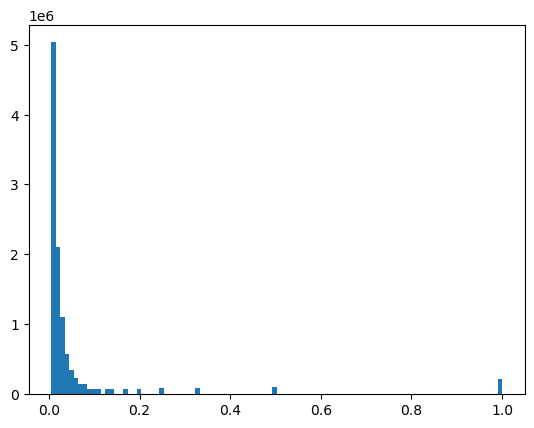

In [9]:
plt.hist(list_vals2, bins=100)

In [10]:
list_vals2 = np.array(list_vals2)
list_vals2[list_vals2 < 0.005].shape

(0,)

In [11]:
np.median(list_vals2)

0.016129032258064516

In [9]:
words_in_common = list(set(words_coexistence_matrix.index).intersection(set(embeddings.index)))

In [10]:
embeddings = embeddings.loc[words_in_common]

In [6]:
sim_mat = matrix_creation.get_similarity_matrix(embeddings[:], metric='cosine', n_neighbors=73)

In [10]:
def get_final_similarity_matrix(similarity_matrix, coexistence_matrix, alpha=0.5):
    sim_mat_vals = similarity_matrix.values
    coex_mat_vals = coexistence_matrix.values
    final_matrix = alpha*sim_mat_vals + (1-alpha)*coex_mat_vals
    return pd.DataFrame(final_matrix, index=similarity_matrix.index, columns=similarity_matrix.columns)

In [12]:
words_in_common = list(set(words_coexistence_matrix.columns).intersection(set(embeddings.index)))

In [9]:
words_in_common

['rye',
 'mexiletine',
 'nonfirearm',
 'pregnenolone',
 'hotdog',
 'norfolk',
 'build',
 'lcds',
 'igs',
 'reperfusion',
 'electrophoretic',
 'grain',
 'uic',
 'antimetatstatic',
 'intervention',
 'athlete',
 'biotransforming',
 'seguimiento',
 'calciuria',
 'saharan',
 'scour',
 'uninfected',
 'microplate',
 'hydrolase',
 'nonlethal',
 'suspect',
 'disentangle',
 'qald',
 'folgende',
 'hypernatremia',
 'sy5y',
 'discrepant',
 'purchase',
 'faba',
 'modulatory',
 '48',
 'mutton',
 'relative',
 'immunosorbent',
 'papillomaviruse',
 'borobudur',
 'internationally',
 '2074',
 'tubo',
 'ardèche',
 'alt',
 'fractionate',
 '224',
 'tracer',
 '137',
 'extracorporeal',
 'aortic',
 'outrage',
 'ss',
 'impending',
 'everywhere',
 'wheezer',
 'congeners',
 '633',
 'evidently',
 'pessimistic',
 'scavenger',
 'insight',
 'cosponsor',
 'clip',
 'opposing',
 'underscore',
 'to',
 'tsnas',
 'cortisol',
 'skill',
 'horizontally',
 'resilience',
 'convincingly',
 'decarboxylase',
 '8014',
 'legitimate',

In [10]:
replaceable_words = clustering.get_replaceable_words(sim_mat, words_coexistence_matrix, alpha=0.5, thresh=0.8)

100%|██████████| 22156/22156 [12:46<00:00, 28.92it/s]


In [11]:
word_graph = clustering.Graph(replaceable_words)

In [12]:
clusters = word_graph.find_all_cycles()
clusters

[{'rye'},
 {'mexiletine'},
 {'firearm', 'nonfirearm'},
 {'pregnenolone'},
 {'hotdog'},
 {'norfolk'},
 {'build'},
 {'lcds'},
 {'igs'},
 {'reperfusion'},
 {'electrophoretic'},
 {'uic'},
 {'grain'},
 {'antimetatstatic'},
 {'intervention'},
 {'athlete'},
 {'biotransforming'},
 {'navarra', 'seguimiento', 'universidad'},
 {'calciuria'},
 {'saharan'},
 {'scour'},
 {'uninfected'},
 {'microplate'},
 {'hydrolase'},
 {'nonlethal'},
 {'suspect'},
 {'disentangle'},
 {'qald'},
 {'erkrankungen', 'folgende', 'roggen', 'zeigen'},
 {'hypernatremia'},
 {'sy5y'},
 {'discrepant'},
 {'purchase'},
 {'faba'},
 {'modulatory'},
 {'48'},
 {'mutton'},
 {'relative'},
 {'immunosorbent'},
 {'papillomaviruse'},
 {'borobudur'},
 {'internationally'},
 {'2074'},
 {'tubo'},
 {'ardèche'},
 {'alt'},
 {'fractionate'},
 {'224'},
 {'tracer'},
 {'137'},
 {'extracorporeal'},
 {'aortic'},
 {'outrage'},
 {'ss'},
 {'impending'},
 {'everywhere'},
 {'wheezer'},
 {'congeners'},
 {'633'},
 {'evidently'},
 {'pessimistic'},
 {'scavenger

In [40]:
clusters.sort(key=lambda x: len(x), reverse=True)

In [41]:
clusters

[{'574',
  'accru',
  'ainsi',
  'algunos',
  'algún',
  'alor',
  'altas',
  'alto',
  'amplia',
  'asma',
  'asociaciones',
  'asociaron',
  'asoció',
  'autorreferida',
  'bajo',
  'basó',
  'cociente',
  'conclusión',
  'confianza',
  'connus',
  'conocido',
  'consumo',
  'contexte',
  'corporal',
  'corporelle',
  'diario',
  'diferencias',
  'différence',
  'débile',
  'embargo',
  'encuesta',
  'enfermedad',
  'entre',
  'estimer',
  'estimé',
  'estudio',
  'existen',
  'facteur',
  'factore',
  'familia',
  'familles',
  'feuille',
  'geográficas',
  'hebdomadaire',
  'hojas',
  'hombre',
  'hombres',
  'homme',
  'hortalizas',
  'ic95',
  'igual',
  'lait',
  'laitier',
  'logistique',
  'logística',
  'lácteo',
  'légumes',
  'marco',
  'marquées',
  'mujeres',
  'méthodes',
  'nacional',
  'observaron',
  'padecer',
  'padecerla',
  'parmi',
  'parte',
  'pequeña',
  'pollo',
  'posibilidades',
  'prevalencia',
  'probabilidad',
  'proporción',
  'prévalence',
  'quelconqu

In [13]:
clust_dict = clustering.clusters_dict(clusters)
clust_dict

{'rye': 0,
 'mexiletine': 1,
 'nonfirearm': 2,
 'firearm': 2,
 'pregnenolone': 3,
 'hotdog': 4,
 'norfolk': 5,
 'build': 6,
 'lcds': 7,
 'igs': 8,
 'reperfusion': 9,
 'electrophoretic': 10,
 'uic': 11,
 'grain': 12,
 'antimetatstatic': 13,
 'intervention': 14,
 'athlete': 15,
 'biotransforming': 16,
 'seguimiento': 17,
 'navarra': 17,
 'universidad': 17,
 'calciuria': 18,
 'saharan': 19,
 'scour': 20,
 'uninfected': 21,
 'microplate': 22,
 'hydrolase': 23,
 'nonlethal': 24,
 'suspect': 25,
 'disentangle': 26,
 'qald': 27,
 'roggen': 28,
 'folgende': 28,
 'erkrankungen': 28,
 'zeigen': 28,
 'hypernatremia': 29,
 'sy5y': 30,
 'discrepant': 31,
 'purchase': 32,
 'faba': 33,
 'modulatory': 34,
 '48': 35,
 'mutton': 36,
 'relative': 37,
 'immunosorbent': 38,
 'papillomaviruse': 39,
 'borobudur': 40,
 'internationally': 41,
 '2074': 42,
 'tubo': 43,
 'ardèche': 44,
 'alt': 45,
 'fractionate': 46,
 '224': 47,
 'tracer': 48,
 '137': 49,
 'extracorporeal': 50,
 'aortic': 51,
 'outrage': 52,
 's

In [14]:
#rewritten = rewrite_corpus({key:cleaned_corpus[key] for key in tqdm(list(cleaned_corpus.keys())[:10])}, clust_dict)
rewritten = clustering.rewrite_corpus(cleaned_corpus, clust_dict)

100%|██████████| 3633/3633 [01:14<00:00, 48.90it/s]


In [15]:
rewritten

{'MED-10': '9467 11211 14766 1850 18623 8133 18738 17979 8989 17816 6158 20737 721 17816 4332 2833 13907 9467 14152 11841 2069 8013 6631 785 13785 785 20982 7489 14357 1306 20631 18073 1850 18623 19089 14273 785 17537 17784 8642 4401 7489 1767 5059 12160 21211 7281 785 1850 18623 1060 6920 9467 19947 6631 18738 9736 21010 8989 785 1850 18623 4755 785 17816 8989 17443 12072 17997 18166 1850 18623 4755 6631 20737 11145 3607 11704 6158 785 2731 18623 16494 10137 17784 9467 11211 3609 14766 13768 785 21005 16124 5752 6158 18738 9437 6790 9315 12160 11211 785 10124 1489 1218 114 1765 67 129 7489 6920 9467 19947 12515 9467 11211 5111 21053 20507 17991 18738 2531 785 11906 4332 11211 9467 11145 785 19764 21269 15875 785 5220 13768 785 21005 5234 5220 11906 10402 785 20820 16124 13424 67 1850 18623 13768 130 13140 13523 3349 9443 14766 2932 1578 9532 7067 956 14766 1297 956 9467 11211 16124 18973 12515 17256 7281 785 1850 18623 1060 6362 169 2589 14766 6362 169 2589 20609 785 7281 5229 4992 70

# Retrieval

## BM25

In [3]:
from rank_bm25 import BM25Okapi
import optuna

class BM25_model:
  def __init__(self, corpus, k1=1.5, b=0.75):
    cleaned_corpus = corpus_processing.preprocess_corpus_dict(corpus)
    self.tokenized_corpus = [cleaned_corpus[key].split(" ") for key in corpus.keys()]
    self.bm25_model = BM25Okapi(self.tokenized_corpus, k1=k1, b=b)
    self.keys = list(corpus.keys())

  def search(self, corpus: dict[str, dict[str, str]], queries: dict[str, str], top_k: int, score_function,**kwargs) -> dict[str, dict[str, float]]:
    results = {}
    for query_id, query in tqdm(queries.items(), desc="tests in progress"):
        # Process the query
        #cleaned_query = preprocess_corpus([query])
        cleaned_query = corpus_processing.clean_tokens(corpus_processing.nlp(query))
        tokenized_query = cleaned_query.split(" ")
        # Apply BM25 to get scores
        scores = self.bm25_model.get_scores(tokenized_query)
        # Sort the scores in descending order and save the results
        ordered_keys_index = np.argsort(scores)[::-1][:top_k]
        sorted_scores = {self.keys[i] : scores[i] for i in ordered_keys_index}
        results[query_id] = sorted_scores
    return results
  

In [7]:
def objective(trial):
    # Suggest values for k1 and b
    k1 = trial.suggest_float("k1", 1.2, 2.0)  # Adjust range as needed
    b = trial.suggest_float("b", 0.0, 1.0)    # BM25's b typically lies between 0 and 1

    # Instantiate the retriever model with the suggested parameters
    retriever = BM25_model(cleaned_corpus, k1=k1, b=b)
    retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
    results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
    # Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
    score = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)[0]['NDCG@10']  # Replace this with your evaluation metric

    return score  # Higher score is better (Optuna minimizes by default)

study = optuna.create_study(direction="maximize")  # Use "minimize" if your score is a loss
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)

[I 2025-01-09 08:51:11,391] A new study created in memory with name: no-name-c149680f-eebe-4ccf-bdf4-8cc357b02ed7
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 88.31it/s] 
[I 2025-01-09 08:51:15,806] Trial 0 finished with value: 0.30397 and parameters: {'k1': 1.689151112584689, 'b': 0.3743315999040079}. Best is trial 0 with value: 0.30397.
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 98.46it/s] 
[I 2025-01-09 08:51:19,592] Trial 1 finished with value: 0.30198 and parameters: {'k1': 1.4126695191350203, 'b': 0.9045533710793888}. Best is trial 0 with value: 0.30397.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 108.99it/s]
[I 2025-01-09 08:51:23,051] Trial 2 finished with value: 0.30077 and parameters: {'k1': 1.3655081127949722, 'b': 0.023618988706922472}. Best is trial 0 with value: 0.30397.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 109.46it/s]
[I 2025-01-09 08:51:26,479] Trial 3 finished with value: 0.30204 and parameters: {'k1': 1.37

{'k1': 1.865819183429756, 'b': 0.48273398944742674}
0.30749


In [4]:
#k1=1.865819183429756, b=0.48273398944742674
model_bm25Okapi = BM25_model(corpus, k1=1.5, b=0.75)

100%|██████████| 382545/382545 [34:24<00:00, 185.29it/s]  


In [5]:
retriever_bm25Okapi = EvaluateRetrieval(model_bm25Okapi, score_function="cos_sim") # or "dot" if you wish dot-product

#### Retrieve dense results (format of results is identical to qrels)
#results = retriever.retrieve(corpus_to_give, {list(queries.keys())[i]:queries[list(queries.keys())[i]] for i in range(50)})
results_bm25Okapi = retriever_bm25Okapi.retrieve(model_bm25Okapi.tokenized_corpus, queries)

#### Evaluate your retrieval using NDCG@k, MAP@K ...
ndcg_bm25Okapi, _map_bm25Okapi, recall_bm25Okapi, precision_bm25Okapi = retriever_bm25Okapi.evaluate(qrels, results_bm25Okapi, retriever_bm25Okapi.k_values)

tests in progress: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


In [7]:
ndcg_bm25Okapi, _map_bm25Okapi, recall_bm25Okapi, precision_bm25Okapi

({'NDCG@1': 0.40816,
  'NDCG@3': 0.3443,
  'NDCG@5': 0.34304,
  'NDCG@10': 0.3192,
  'NDCG@100': 0.44109,
  'NDCG@1000': 0.5437},
 {'MAP@1': 0.02626,
  'MAP@3': 0.0531,
  'MAP@5': 0.08385,
  'MAP@10': 0.12204,
  'MAP@100': 0.20358,
  'MAP@1000': 0.22042},
 {'Recall@1': 0.02626,
  'Recall@3': 0.07066,
  'Recall@5': 0.12439,
  'Recall@10': 0.20646,
  'Recall@100': 0.55401,
  'Recall@1000': 0.86524},
 {'P@1': 0.42857,
  'P@3': 0.34694,
  'P@5': 0.3551,
  'P@10': 0.30204,
  'P@100': 0.09286,
  'P@1000': 0.01612})

## Mine

In [16]:
def objective(trial):
    # Suggest values for k1 and b
    k1 = trial.suggest_float("k1", 1.2, 2.0)  # Adjust range as needed
    #b = trial.suggest_float("b", 0.0, 1.0)    # BM25's b typically lies between 0 and 1
    b = 0.75

    # Instantiate the retriever model with the suggested parameters
    retriever = retriever_model.Retriever(rewritten, clust_dict, k1=k1, b=b)
    retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
    results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
    # Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
    score = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)[0]['NDCG@10']  # Replace this with your evaluation metric

    return score  # Higher score is better (Optuna minimizes by default)

study = optuna.create_study(direction="maximize")  # Use "minimize" if your score is a loss
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)


[I 2025-01-10 14:55:19,815] A new study created in memory with name: no-name-931bfa38-066e-439d-bbdf-2aadd0f4c0fe
tests in progress: 100%|██████████| 323/323 [00:05<00:00, 57.87it/s]
[I 2025-01-10 14:55:26,214] Trial 0 finished with value: 0.29995 and parameters: {'k1': 1.2287223545403996}. Best is trial 0 with value: 0.29995.
tests in progress: 100%|██████████| 323/323 [00:04<00:00, 65.16it/s]
[I 2025-01-10 14:55:31,717] Trial 1 finished with value: 0.30066 and parameters: {'k1': 1.2750775582117548}. Best is trial 1 with value: 0.30066.
tests in progress: 100%|██████████| 323/323 [00:04<00:00, 64.90it/s]
[I 2025-01-10 14:55:37,240] Trial 2 finished with value: 0.30235 and parameters: {'k1': 1.963075281282854}. Best is trial 2 with value: 0.30235.
tests in progress: 100%|██████████| 323/323 [00:05<00:00, 63.59it/s]
[I 2025-01-10 14:55:42,921] Trial 3 finished with value: 0.30364 and parameters: {'k1': 1.5474879988686085}. Best is trial 3 with value: 0.30364.
tests in progress: 100%|███

{'k1': 1.609218899336134}
0.30398


In [23]:
# k1= 1.8891134483579508, b=0.4800276968019695
# base : k1 = 1.5, b = 0.75
model_okapi = retriever_model.Retriever(rewritten, clust_dict, k1= 1.61, b=0.75)

In [24]:
retriever_okapi = EvaluateRetrieval(model_okapi, score_function="cos_sim") # or "dot" if you wish dot-product

#### Retrieve dense results (format of results is identical to qrels)
#results = retriever.retrieve(corpus_to_give, {list(queries.keys())[i]:queries[list(queries.keys())[i]] for i in range(50)})
results_okapi = retriever_okapi.retrieve(model_okapi.tokenized_corpus, queries)

#### Evaluate your retrieval using NDCG@k, MAP@K ...
ndcg_okapi, _map_okapi, recall_okapi, precision_okapi = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)


tests in progress: 100%|██████████| 323/323 [00:03<00:00, 88.91it/s] 


In [25]:
ndcg_okapi, _map_okapi, recall_okapi, precision_okapi

({'NDCG@1': 0.40093,
  'NDCG@3': 0.36413,
  'NDCG@5': 0.33404,
  'NDCG@10': 0.30398,
  'NDCG@100': 0.26349,
  'NDCG@1000': 0.32944},
 {'MAP@1': 0.05252,
  'MAP@3': 0.09096,
  'MAP@5': 0.10017,
  'MAP@10': 0.11407,
  'MAP@100': 0.13616,
  'MAP@1000': 0.14687},
 {'Recall@1': 0.05252,
  'Recall@3': 0.10464,
  'Recall@5': 0.11888,
  'Recall@10': 0.14666,
  'Recall@100': 0.24512,
  'Recall@1000': 0.46568},
 {'P@1': 0.40867,
  'P@3': 0.33746,
  'P@5': 0.2805,
  'P@10': 0.21734,
  'P@100': 0.06458,
  'P@1000': 0.01771})

In [ ]:
indexes = list(ndcg_okapi.keys()) + list(_map_okapi.keys()) + list(recall_okapi.keys()) + list(precision_okapi.keys())

values_mine_okapi = list(ndcg_okapi.values()) + list(_map_okapi.values()) + list(recall_okapi.values()) + list(precision_okapi.values())
values_bm25Okapi = list(ndcg_bm25Okapi.values()) + list(_map_bm25Okapi.values()) + list(recall_bm25Okapi.values()) + list(precision_bm25Okapi.values())

comparison = pd.DataFrame({'indexes':indexes, 'mine_okapi':values_mine_okapi, 'bm25Okapi':values_bm25Okapi})
comparison.columns = ['metrics', 'mine_okapi', 'bm25Okapi']
comparison.set_index('metrics', inplace=True)

comparison['diff'] = comparison['mine_okapi'] - comparison['bm25Okapi']
comparison

In [65]:
indexes = list(ndcg_okapi.keys()) + list(_map_okapi.keys()) + list(recall_okapi.keys()) + list(precision_okapi.keys())

values_mine_okapi = list(ndcg_okapi.values()) + list(_map_okapi.values()) + list(recall_okapi.values()) + list(precision_okapi.values())
#values_bm25Okapi = list(ndcg_bm25Okapi.values()) + list(_map_bm25Okapi.values()) + list(recall_bm25Okapi.values()) + list(precision_bm25Okapi.values())

comparison = pd.DataFrame({'indexes':indexes, 'mine_okapi':values_mine_okapi})#, 'bm25Okapi':values_bm25Okapi})
comparison.columns = ['metrics', 'mine_okapi']#, 'bm25Okapi']
comparison.set_index('metrics', inplace=True)

#comparison['diff'] = comparison['mine_okapi'] - comparison['bm25Okapi']
comparison.T.to_csv('comparison_nfcorpus.csv', index=False, mode = 'a')

In [35]:
print('Model better than bm25 for ' + str(comparison[comparison['diff'] > 0]['diff'].count()) + '/' + str(len(indexes))+ ' metrics')
print('Model worse than bm25 for ' + str(comparison[comparison['diff'] < 0]['diff'].count()) + '/' + str(len(indexes))+ ' metrics')
print('Model equal to bm25 for ' + str(comparison[comparison['diff'] == 0]['diff'].count()) + '/' + str(len(indexes))+ ' metrics')

Model better than bm25 for 5/24 metrics
Model worse than bm25 for 19/24 metrics
Model equal to bm25 for 0/24 metrics


## Finetuning

In [8]:
def objective(trial):
    # Suggest values for k1 and b
    #k1 = trial.suggest_float("k1", 1.2, 2.0)  # Adjust range as needed
    #b = trial.suggest_float("b", 0.0, 1.0)    # BM25's b typically lies between 0 and 1
    n_neighbors = trial.suggest_int("n_neighbors", 5, 100)
    alpha = trial.suggest_float("alpha", 0.3, 1.0)
    thresh = trial.suggest_float("thresh", 0.4, 1.0)
    #metric = trial.suggest_categorical("metric", ['cosine', 'euclidean'])
    metric = 'cosine'
    
    # Instantiate the retriever model with the suggested parameters
    retriever = retriever_model.FullRetriever(embeddings, n_neighbors = n_neighbors, alpha=alpha, thresh = thresh, metric = metric, k1 = 1.5, b = 0.75, coexistence_matrix = words_coexistence_matrix)
    retriever.fit(cleaned_corpus, is_clean=True)

    retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
    results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
    # Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
    scores = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)  # Replace this with your evaluation metric
    score = scores[0]['NDCG@10']

    ndcg_okapi, _map_okapi, recall_okapi, precision_okapi = scores
    indexes = list(ndcg_okapi.keys()) + list(_map_okapi.keys()) + list(recall_okapi.keys()) + list(precision_okapi.keys())

    values_mine_okapi = list(ndcg_okapi.values()) + list(_map_okapi.values()) + list(recall_okapi.values()) + list(precision_okapi.values())

    comparison = pd.DataFrame({'indexes':indexes, f'n_neighbors={n_neighbors} alpha={alpha} thresh={thresh} metric={metric}':values_mine_okapi})
    comparison.columns = ['metrics', f'n_neighbors={n_neighbors} alpha={alpha} thresh={thresh} metric={metric}']
    comparison.set_index('metrics', inplace=True)

    comparison.T.to_csv('comparison_nfcorpus.csv', index=True, mode = 'a', header=False)
    
    return score  # Higher score is better (Optuna minimizes by default)

study = optuna.create_study(direction="maximize")  # Use "minimize" if your score is a loss
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)

[I 2025-01-11 22:38:38,371] A new study created in memory with name: no-name-2364f87f-014c-4169-9c47-c1572b5f9bca
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 91.99it/s] 
[I 2025-01-11 23:11:52,930] Trial 0 finished with value: 0.27838 and parameters: {'n_neighbors': 45, 'alpha': 0.8859024180037227, 'thresh': 0.7974211837509664}. Best is trial 0 with value: 0.27838.
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 100.36it/s]
[I 2025-01-11 23:21:21,751] Trial 1 finished with value: 0.30364 and parameters: {'n_neighbors': 51, 'alpha': 0.3946918808963106, 'thresh': 0.7789542766435167}. Best is trial 1 with value: 0.30364.
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 104.90it/s]
[I 2025-01-11 23:30:37,003] Trial 2 finished with value: 0.27711 and parameters: {'n_neighbors': 82, 'alpha': 0.4371255940196473, 'thresh': 0.46507622759811285}. Best is trial 1 with value: 0.30364.
tests in progress: 100%|██████████| 323/323 [00:03<00:00, 103.37it/s]
[I 2025-01-

{'n_neighbors': 73, 'alpha': 0.7618809756468575, 'thresh': 0.7543853066734008}
0.30843


In [ ]:
'''
best_n_neighbors = study.best_params['n_neighbors']
best_alpha = study.best_params['alpha']
best_thresh = study.best_params['thresh']

best_n_neighbors, best_alpha, best_thresh
'''
best_n_neighbors = 73
best_alpha = 0.7618809756468575

best_thresh = 0.7543853066734008

In [ ]:
retriever = retriever_model.FullRetriever(embeddings, n_neighbors = best_n_neighbors, alpha=best_alpha, thresh = best_thresh, metric = 'cosine', k1 = 1.5, b = 0.75, coexistence_matrix = words_coexistence_matrix, thresh_prob=0)
retriever.fit(cleaned_corpus, is_clean=True)

retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
# Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
scores = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)  # Replace this with your evaluation metric
scores

  6%|▌         | 1703/29043 [03:22<1:17:46,  5.86it/s]Exception in thread Thread-5:
Traceback (most recent call last):
  File "c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\ipykernel\iostream.py", line 142, in _event_pipe
    event_pipe = self._local.event_pipe
                 ^^^^^^^^^^^^^^^^^^^^^^
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\maxim\anaconda3\envs\research_ir\Lib\threading.py", line 1073, in _bootstrap_inner
  6%|▌         | 1705/29043 [03:57<65:41:06,  8.65s/it]    self.run()
  File "c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\tqdm\_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\tqdm\std.py", line 1347, in refresh
    self.display()
  File "c:\Users\maxim\anaconda3\envs\research_ir\Lib\site-packages\tqdm\std.py

In [44]:
from rank_bm25 import BM25Okapi, BM25L, BM25Plus
def objective(trial):
    # Suggest values for k1 and b
    k1 = trial.suggest_float("k1", 0.0, 2.0)  # Adjust range as needed
    b = trial.suggest_float("b", 0.0, 1.0)    # BM25's b typically lies between 0 and 1
    epsilon = trial.suggest_float("epsilon", 0.0, 1.0)
    #epsilon = 0.0
    #delta = 0.75

    # Instantiate the retriever model with the suggested parameters

    retriever.retriever.bm25_model = BM25Okapi(retriever.tokenized_corpus, k1=k1, b=b, epsilon=epsilon)
    retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
    results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
    # Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
    score = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)[0]['NDCG@10']  # Replace this with your evaluation metric

    return score  # Higher score is better (Optuna minimizes by default)

study = optuna.create_study(direction="maximize")  # Use "minimize" if your score is a loss
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)

[I 2025-01-13 21:47:08,012] A new study created in memory with name: no-name-16f7e08d-f51f-4803-9b7a-ba7e9dfc6298
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 112.06it/s]
[I 2025-01-13 21:47:11,142] Trial 0 finished with value: 0.31755 and parameters: {'k1': 1.8905898179102507, 'b': 0.005728593236105861, 'epsilon': 0.8696500411402038}. Best is trial 0 with value: 0.31755.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 108.55it/s]
[I 2025-01-13 21:47:14,343] Trial 1 finished with value: 0.30584 and parameters: {'k1': 0.3443797360852101, 'b': 0.6003319036056877, 'epsilon': 0.0042630522135381765}. Best is trial 0 with value: 0.31755.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 111.26it/s]
[I 2025-01-13 21:47:17,478] Trial 2 finished with value: 0.31709 and parameters: {'k1': 1.065819738796474, 'b': 0.4518048659084476, 'epsilon': 0.3893223609095169}. Best is trial 0 with value: 0.31755.
tests in progress: 100%|██████████| 323/323 [00:02<00:00, 114.39it

{'k1': 1.9054211598230129, 'b': 0.5971507702716906, 'epsilon': 0.7992503732505253}
0.32375


In [11]:
from rank_bm25 import BM25Okapi, BM25L, BM25Plus

#retriever.retriever.bm25_model = BM25Okapi(retriever.tokenized_corpus, k1=study.best_params['k1'], b=study.best_params['b'], epsilon=study.best_params['epsilon'])
retriever.retriever.bm25_model = BM25Okapi(retriever.tokenized_corpus, k1=1.9, b=0.6, epsilon=0.4)

retriever_okapi = EvaluateRetrieval(retriever, score_function="cos_sim") # or "dot" if you wish dot-product
results_okapi = retriever_okapi.retrieve(retriever.tokenized_corpus, queries)
# Evaluate the model (implement your own evaluation logic, e.g., compute mean reciprocal rank)
scores = retriever_okapi.evaluate(qrels, results_okapi, retriever_okapi.k_values)  # Replace this with your evaluation metric
scores

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


tests in progress: 100%|██████████| 1406/1406 [09:31<00:00,  2.46it/s]


({'NDCG@1': 0.22262,
  'NDCG@3': 0.35683,
  'NDCG@5': 0.40825,
  'NDCG@10': 0.46186,
  'NDCG@100': 0.51216,
  'NDCG@1000': 0.51541},
 {'MAP@1': 0.22262,
  'MAP@3': 0.32361,
  'MAP@5': 0.35206,
  'MAP@10': 0.37406,
  'MAP@100': 0.38583,
  'MAP@1000': 0.38597},
 {'Recall@1': 0.22262,
  'Recall@3': 0.45306,
  'Recall@5': 0.57824,
  'Recall@10': 0.74467,
  'Recall@100': 0.96515,
  'Recall@1000': 0.99004},
 {'P@1': 0.22262,
  'P@3': 0.15102,
  'P@5': 0.11565,
  'P@10': 0.07447,
  'P@100': 0.00965,
  'P@1000': 0.00099})

In [19]:
retriever.coexistence_matrix.loc['imidazo']

harcourt          0.0
3083              0.0
inspiratory       0.0
polymerization    0.0
derange           0.0
                 ... 
panoply           0.0
meningeal         0.0
1,026             0.0
arthroplasty      0.0
0.0186            0.0
Name: imidazo, Length: 29452, dtype: float64

In [20]:
test = list(retriever.coexistence_matrix.loc['imidazo'].index)
np.random.shuffle(test)

test_serie = pd.Series(np.random.random(len(test)), index=test)

In [22]:
test_serie + retriever.coexistence_matrix.loc['imidazo']

$        0.314706
'hort    0.575880
(-8      0.032149
(=       0.479259
+        0.382991
           ...   
⩽5       0.851422
⩾2       0.067561
⩾20      0.253161
⩾25      0.922274
⩾f3      0.336307
Length: 29452, dtype: float64

# Anserini 

In [19]:
import os
 
# Définir JAVA_HOME dans le script Python
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-23'  # Remplacez par votre chemin exact
os.environ['PATH'] = os.environ['JAVA_HOME'] + r'\bin;' + os.environ['PATH']

from pyserini.search.lucene import LuceneSearcher

Exception: Unable to create jni env, no jvm dll found.